# Load Necessary Libraries and Modules

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    precision_recall_curve, auc
)

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Define Utility Functions

In [ ]:
def load_data(path, header):
    try:
        df = pd.read_csv(path, header=header)
    except FileNotFoundError:
        print("File not found in directory.")

    return df

In [ ]:
def plot_distribution(df, column, bins=30, title=None, xlabel=None, figsize=(8, 4)):
    """
    Plots a histogram with KDE for a specified column in a DataFrame.
    """
    sns.set(style="whitegrid")
    plt.figure(figsize=figsize)
    sns.histplot(df[column], bins=bins, kde=True)
    plt.title(title if title else f"{column} Distribution")
    plt.xlabel(xlabel if xlabel else column)
    plt.show()

In [ ]:
def plot_default_rate_by_age_group(df, age_col='AGE', target_col='default payment next month',
                                   bins=[20, 30, 40, 50, 60, 70, 80], figsize=(8, 4)):
    """
    Plots the default rate by age group using barplot.
    """
    df = df.copy()
    df['age_group'] = pd.cut(df[age_col], bins=bins)

    plt.figure(figsize=figsize)
    sns.barplot(data=df, x='age_group', y=target_col)
    plt.title("Default Rate by Age Group")
    plt.ylabel("Default Rate")
    plt.xlabel("Age Group")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_target_distribution(df, target_col='default payment next month', figsize=(6, 4)):
    """
    Plots the distribution of a binary target variable using countplot.
    """
    plt.figure(figsize=figsize)
    sns.countplot(x=target_col, data=df)
    plt.title("Target Class Distribution")
    plt.xlabel("Default (0 = No, 1 = Yes)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

In [ ]:
def max_consecutive_delay(row):
    """
    Calculate the consecutive delays in payment.
    """
    streak = max_streak = 0
    for col in ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']:
        if row[col] > 0:
            streak += 1
            max_streak = max(max_streak, streak)
        else:
            streak = 0
    return max_streak

In [ ]:
def expanded_eda(df, target_column='TARGET', engineered_features=None, heatmap_figsize=(20, 15), boxplot_figsize=(15, 4), n_cols=3):
    """
    Performs an expanded EDA including a correlation heatmap and boxplots of key engineered features vs. target.
    """
    # Select numeric columns and drop the target if present
    numeric_cols = df.select_dtypes(include=np.number).columns
    if target_column in numeric_cols:
        numeric_cols = numeric_cols.drop(target_column)

    # Compute correlation matrix
    correlation_matrix = df[numeric_cols].corr()

    # Plot heatmap
    plt.figure(figsize=heatmap_figsize)
    sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt=".2f")
    plt.title('Correlation Matrix of Numerical Features')
    plt.show()

    if engineered_features:
        print("--- Distribution of Key Engineered Features vs. Target ---")

        # Filter valid features
        valid_features = [f for f in engineered_features if f in df.columns]
        n_features = len(valid_features)
        n_rows = (n_features + n_cols - 1) // n_cols

        plt.figure(figsize=(boxplot_figsize[0], n_rows * boxplot_figsize[1]))
        for i, feature in enumerate(valid_features):
            plt.subplot(n_rows, n_cols, i + 1)
            sns.boxplot(x=target_column, y=feature, data=df)
            plt.title(f'{feature} Distribution by {target_column}')

        plt.tight_layout()
        plt.show()

In [ ]:
def compute_trend(values):
    """
    Calculate slope using covariance/variance.
    """
    x = np.arange(1, 7)
    y = values.values
    x_mean, y_mean = x.mean(), y.mean()
    numerator = ((x - x_mean) * (y - y_mean)).sum()
    denominator = ((x - x_mean) ** 2).sum()
    return numerator / denominator if denominator != 0 else 0

In [ ]:
def engineer_features(df):
    # Make a copy to avoid modifying the original DataFrame
    df = df.copy()
    if 'ID' in df.columns:
        df = df.drop('ID', axis=1)

    # Rename target column for easier access
    df = df.rename(columns={'default payment next month': 'TARGET'})

    # 1. Create Demographic/Static Features
    # Age grouping
    age_bins = [20, 30, 40, 50, 60, 80]
    df['age_group'] = pd.cut(df['AGE'], bins=age_bins, labels=False, right=False)
    df['age_group'] = df['age_group'].fillna(-1).astype(int) # Handle potential NaNs if age is outside bins
    df['is_in_working_age'] = ((df['AGE'] >= 20) & (df['AGE'] <= 60)).astype(int)

    # Education grouping
    edu_map = {0:'Unknown', 1:'Graduate School', 2:'University', 3:'High School', 4:'Others', 5:'Unknown', 6:'Unknown'}
    df['education_group'] = df['EDUCATION'].map(edu_map)

    # Marriage grouping
    marriage_map = {0:"Others", 1:"Married", 2:"Single", 3:"Others"}
    df['marriage_group'] = df['MARRIAGE'].map(marriage_map)

    # 2. Create Credit Utilization Features
    for m in range(1, 7):
        df[f'util_{m}'] = df[f'BILL_AMT{m}'] / df['LIMIT_BAL']
        df[f'util_{m}'] = df[f'util_{m}'].fillna(0)
    util_cols = [f'util_{m}' for m in range(1, 7)]
    df['util_avg'] = df[util_cols].mean(axis=1)
    df['util_max'] = df[util_cols].max(axis=1)
    df['util_std'] = df[util_cols].std(axis=1).fillna(0)
    df['limit_to_age'] = df['LIMIT_BAL'] / df['AGE']

    # 3. Create Payment Behaviour Features
    for m in range(1, 7):
        bill_col, pay_col = f'BILL_AMT{m}', f'PAY_AMT{m}'
        safe_bill_amt = df[bill_col].replace(0, 1) # Create a safe bill amount column for division
        safe_bill_amt[safe_bill_amt < 0] = 1 # Handle cases where bill amount might be negative
        df[f'pay_ratio_{m}'] = df[pay_col] / safe_bill_amt
    pay_ratio_cols = [f'pay_ratio_{m}' for m in range(1, 7)]
    df['pay_ratio_avg'] = df[pay_ratio_cols].mean(axis=1)
    df['pay_ratio_min'] = df[pay_ratio_cols].min(axis=1)
    # Count months where payment amount was exactly zero
    df['zero_pay_count'] = sum((df[f'PAY_AMT{m}'] == 0).astype(int) for m in range(1, 7))
    # Count months where payment was >= bill amount (considered 'full' payment)
    df['full_pay_count'] = sum((df[f'PAY_AMT{m}'] >= df[f'BILL_AMT{m}']).astype(int) for m in range(1, 7))

    # 4. Create Features related to Delinquency/Payment History
    pay_cols = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
    # Count of months with actual delay (status > 0)
    df['delinquency_count'] = (df[pay_cols] > 0).sum(axis=1)
    # Count of months paid duly (status == -1)
    df['count_paid_duly'] = (df[pay_cols] == -1).sum(axis=1)
    # Count of months with revolving credit (status == 0)
    df['count_revolving'] = (df[pay_cols] == 0).sum(axis=1)
    # Count of months with no consumption/paid off (status == -2)
    df['count_no_consumption'] = (df[pay_cols] == -2).sum(axis=1)
    # Maximum delay status across the months
    df['max_delay'] = df[pay_cols].max(axis=1)
    # Longest consecutive streak of being delayed (status > 0)
    df['consecutive_delay_streak'] = df.apply(max_consecutive_delay, axis=1)

    # 5. Create Temporal/Trend Features
    # Calculate change in bill amount month-over-month
    for m in range(1, 6):
        df[f'delta_bill_{m+1}'] = df[f'BILL_AMT{m+1}'] - df[f'BILL_AMT{m}']
    # Calculate change in payment amount month-over-month
    for m in range(1, 6):
        df[f'delta_pay_{m+1}'] = df[f'PAY_AMT{m+1}'] - df[f'PAY_AMT{m}']

    bill_cols = [f'BILL_AMT{m}' for m in range(1, 7)]
    pay_cols_amt = [f'PAY_AMT{m}' for m in range(1, 7)]
    util_cols = [f'util_{m}' for m in range(1, 7)]

    df['bill_trend'] = df[bill_cols].apply(compute_trend, axis=1)
    df['pay_trend'] = df[pay_cols_amt].apply(compute_trend, axis=1)
    df['util_trend'] = df[util_cols].apply(compute_trend, axis=1)

    # 6. Aggregated Statistical Features
    df['total_bill'] = df[bill_cols].sum(axis=1)
    df['total_pay'] = df[pay_cols_amt].sum(axis=1)
    # Difference between total billed and total paid over 6 months
    df['bill_pay_diff'] = df['total_bill'] - df['total_pay']
    # Standard deviation of bill amounts
    df['bill_std'] = df[bill_cols].std(axis=1).fillna(0)
    # Standard deviation of payment amounts
    df['pay_std'] = df[pay_cols_amt].std(axis=1).fillna(0)
    # Ratio of total payments to total bills
    df['bill_to_pay_ratio'] = df['total_pay'] / df['total_bill'].replace(0, 1)

    # 7. Interaction Features (Using Mapped/Grouped Variables)
    # Interaction between credit limit and average utilization
    df['limitBal_utilAvg_interaction'] = df['LIMIT_BAL'] * df['util_avg']
    # Interaction between numerical age group and delinquency count
    df['ageGroup_delinquency_interaction'] = df['age_group'] * df['delinquency_count']
    # Interaction between age group and limit
    df['age_limit_interaction'] = df['age_group'] * df['LIMIT_BAL']

    cols_to_drop = ['AGE', 'EDUCATION', 'MARRIAGE'] + pay_cols
    df = df.drop(columns=cols_to_drop, errors='ignore')

    # Clean up column names (remove special characters for models like XGBoost)
    df.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in df.columns]

    return df

# EDA

The data analysis will follow these steps:
1. First, we will summarize basic statistics of the dataset such as the number of records, number of features, number of NaN values, etc.
2. Next, we will do some data preprocessing and clean the data.
3. We will also visualize key distributions (age, payments, default rates) and draw observations from each chart.

In [ ]:
df = load_data("taiwan_default_credit_dataset.csv", header=1)
df.head(5)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ID,30000.0,15000.500000,8660.398374,1.0,7500.75,15000.5,22500.25,30000.0
LIMIT_BAL,30000.0,167484.322667,129747.661567,10000.0,50000.00,140000.0,240000.00,1000000.0
SEX,30000.0,1.603733,0.489129,1.0,1.00,2.0,2.00,2.0
EDUCATION,30000.0,1.853133,0.790349,0.0,1.00,2.0,2.00,6.0
MARRIAGE,30000.0,1.551867,0.521970,0.0,1.00,2.0,2.00,3.0
AGE,30000.0,35.485500,9.217904,21.0,28.00,34.0,41.00,79.0
PAY_0,30000.0,-0.016700,1.123802,-2.0,-1.00,0.0,0.00,8.0
PAY_2,30000.0,-0.133767,1.197186,-2.0,-1.00,0.0,0.00,8.0
PAY_3,30000.0,-0.166200,1.196868,-2.0,-1.00,0.0,0.00,8.0
PAY_4,30000.0,-0.220667,1.169139,-2.0,-1.00,0.0,0.00,8.0


In [ ]:
df.isnull().sum()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64

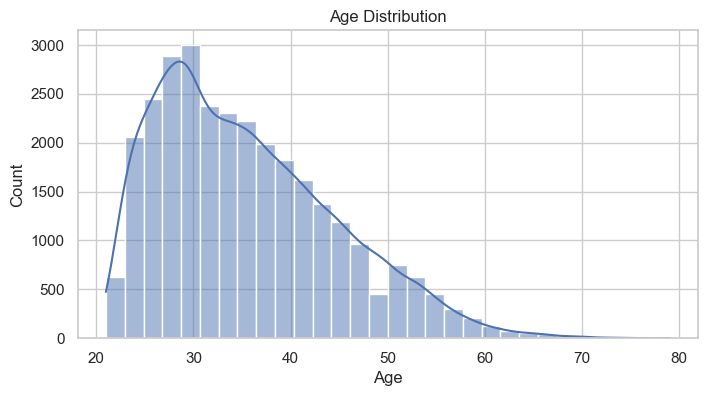

In [ ]:
plot_distribution(df, column='AGE', title="Age Distribution", xlabel="Age")

**Observations and Conclusion**:
- The age spans from around 20 to 80 years. The most common age appears to be between 30 and 35 years, where the histogram peaks.
- The distribution is right-skewed (positively skewed), meaning: Majority of individuals are younger (20–40) and fewer individuals are older (50+).

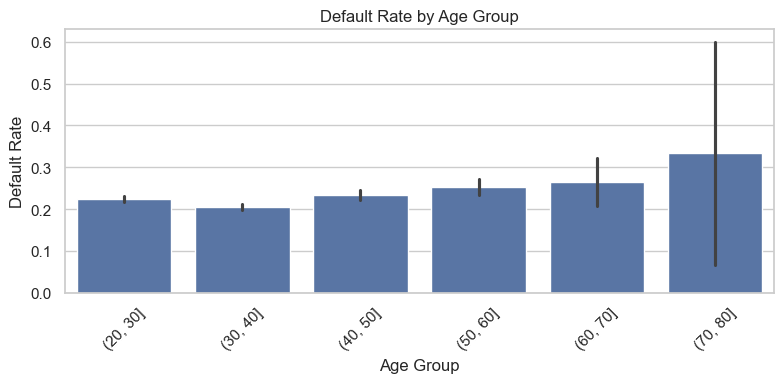

In [ ]:
plot_default_rate_by_age_group(df)

**Observations and Conclusion**:
- The data suggests that younger borrowers (20–40) tend to default less, while default risk increases as borrowers get older, particularly after age 60.
- The 30–40 age group has the lowest default rate (~0.20).
- The 70–80 age group shows the highest default rate (~0.33), though this comes with a large error bar, indicating low sample size or high variability.

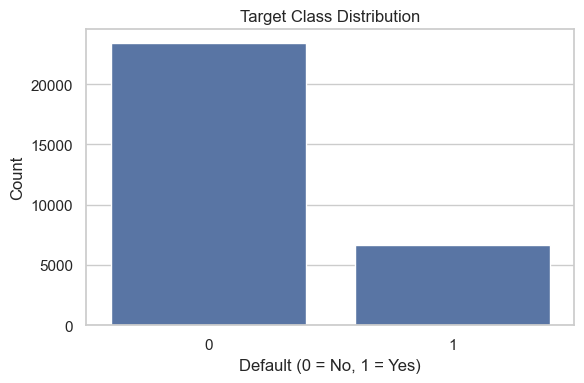

In [ ]:
plot_target_distribution(df)

# Feature Engineering and Modelling

### 1. Feature Engineering

In [ ]:
print("Starting feature engineering...")
df_engineered = engineer_features(df)
print(f"Shape after engineering: {df_engineered.shape}")
df_engineered.head(5)

Starting feature engineering...
Shape after engineering: (30000, 67)


,LIMIT_BAL,SEX,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,...,util_trend,total_bill,total_pay,bill_pay_diff,bill_std,pay_std,bill_to_pay_ratio,limitBal_utilAvg_interaction,ageGroup_delinquency_interaction,age_limit_interaction
0,20000,2,3913,3102,689,0,0,0,0,689,...,-0.042229,7704,689,7015,1761.633219,281.283072,0.089434,1284.000000,0,0
1,120000,2,2682,1725,2682,3272,3455,3261,0,1000,...,0.002065,17077,5000,12077,637.967841,752.772653,0.292791,2846.166667,0,0
2,90000,2,29239,14027,13559,14331,14948,15549,1518,1500,...,-0.020608,101653,11018,90635,6064.518593,1569.815488,0.108388,16942.166667,0,90000
3,50000,2,46990,48233,49291,28314,28959,29547,2000,2019,...,-0.094865,231334,8388,222946,10565.793518,478.058155,0.036259,38555.666667,0,50000
4,50000,1,8617,5670,35835,20940,19146,19131,2000,36681,...,0.044630,109339,59049,50290,10668.590074,13786.230736,0.540054,18223.166667,0,150000


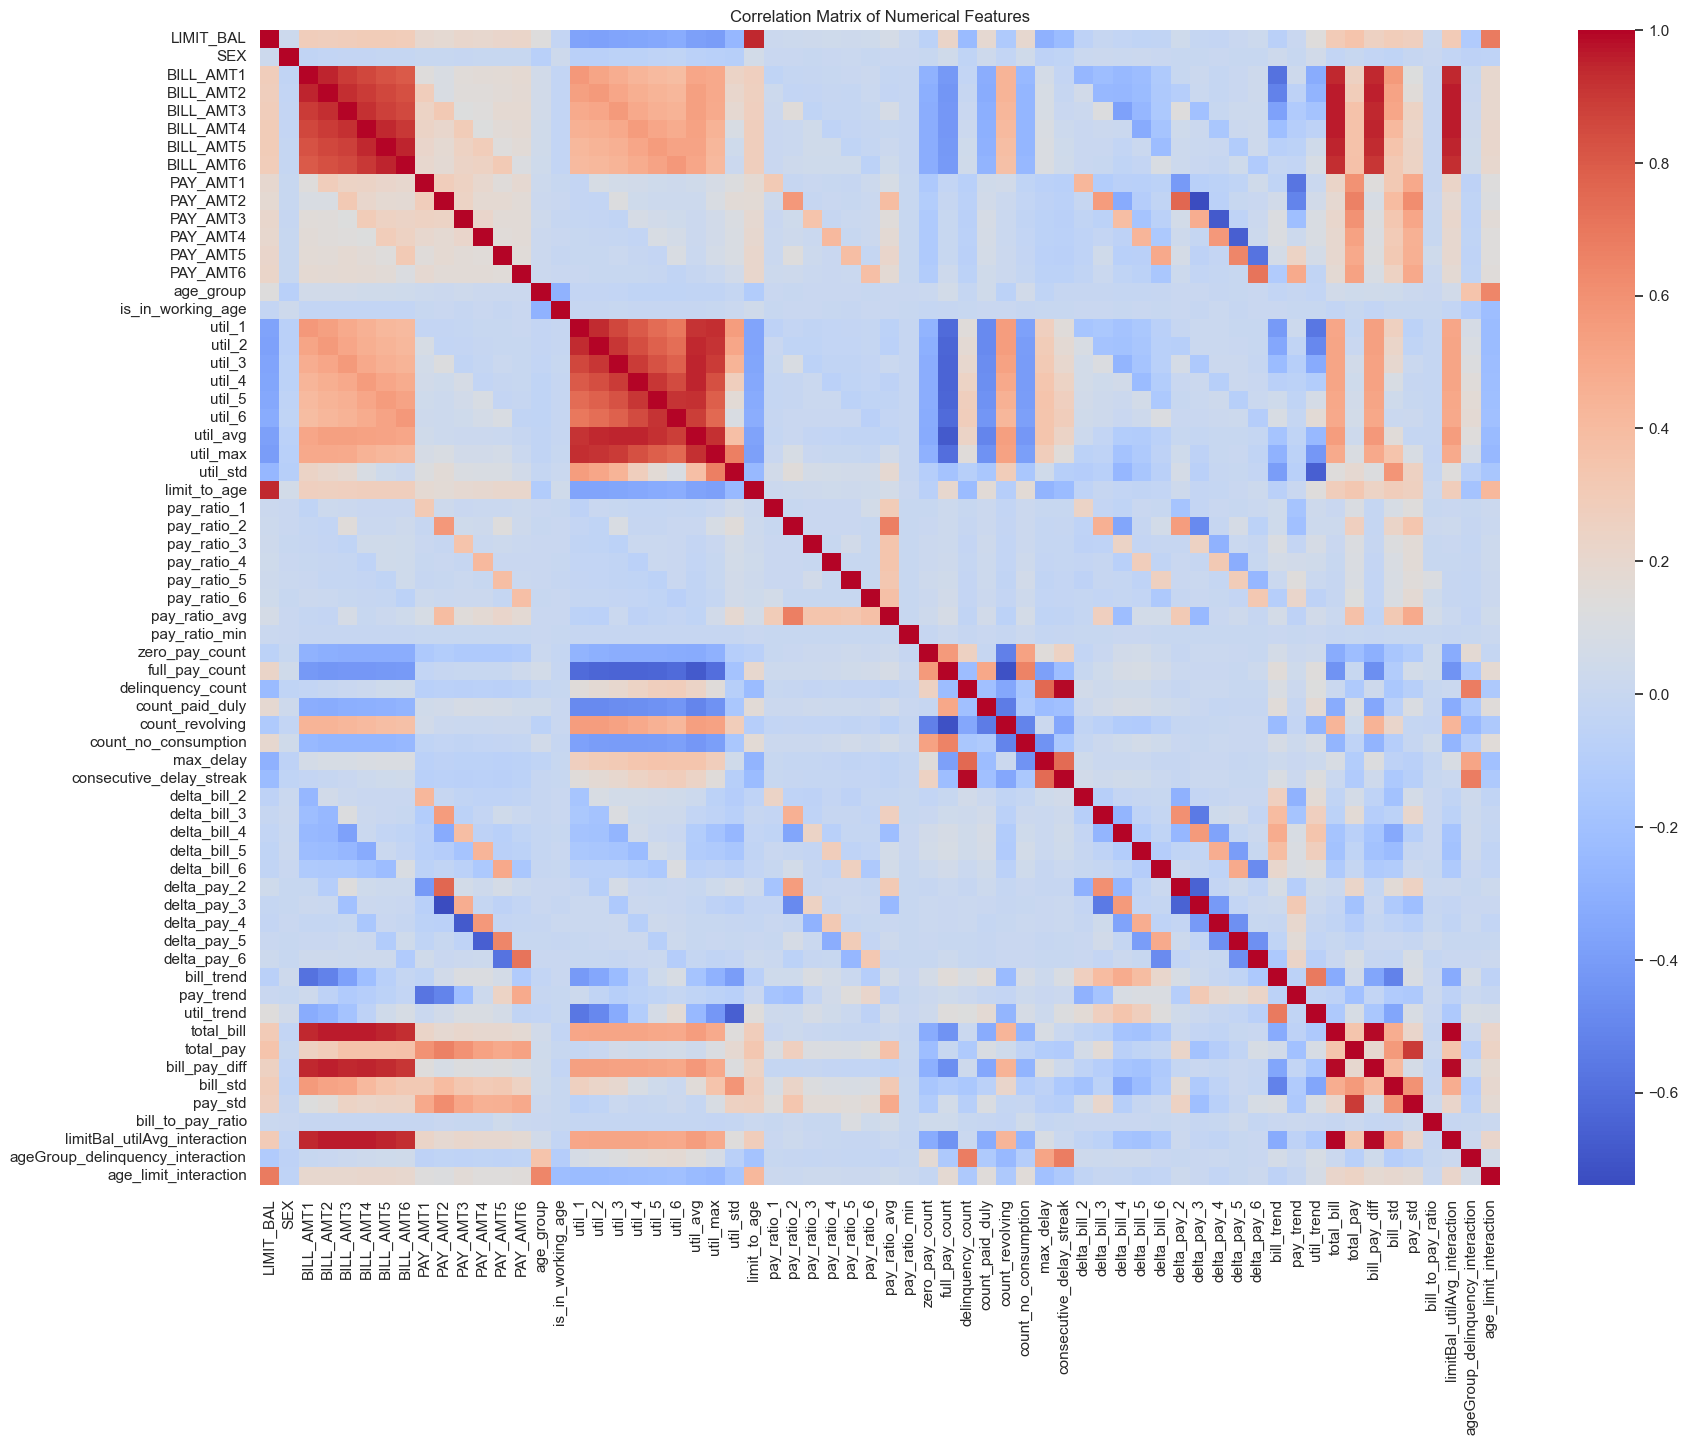

--- Distribution of Key Engineered Features vs. Target ---


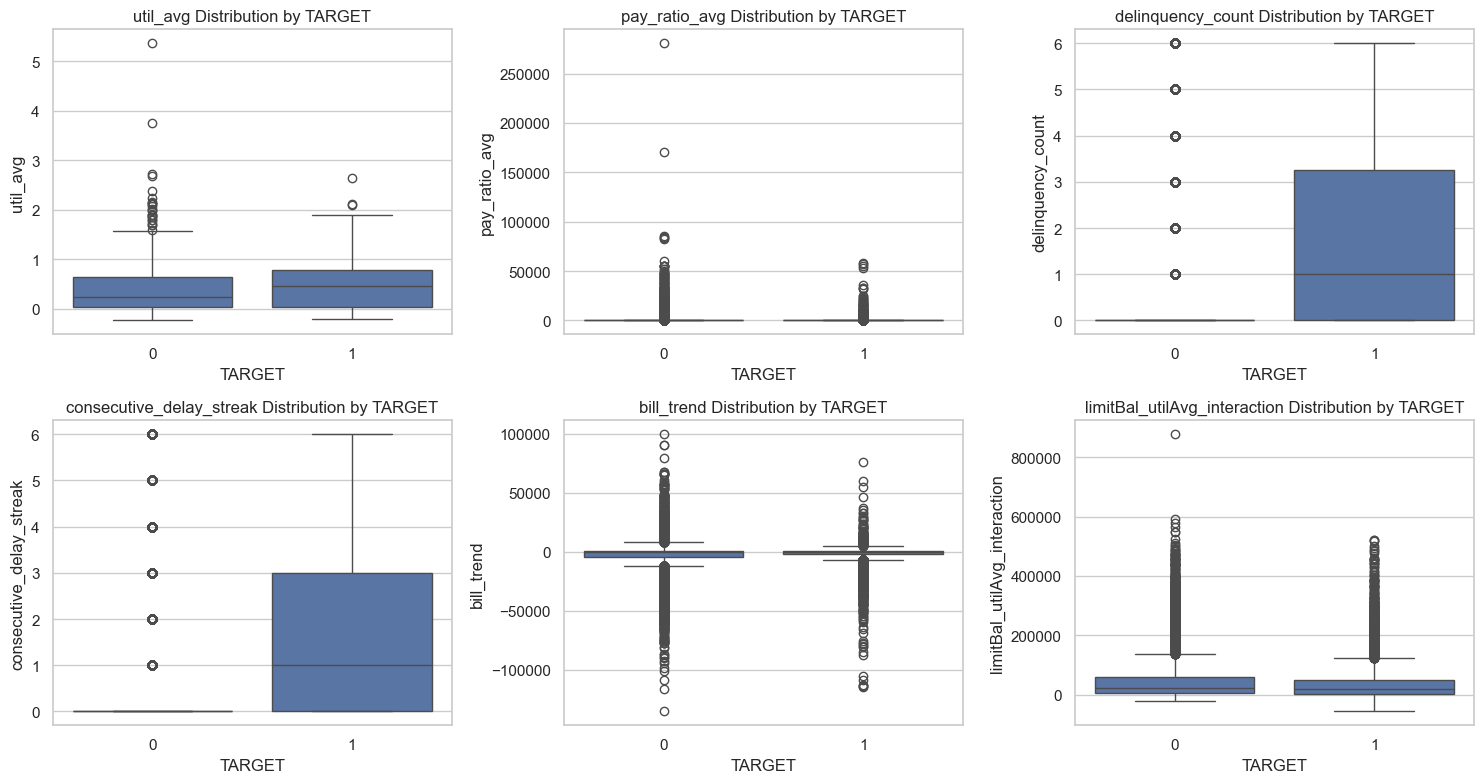

In [ ]:
key_features = ['util_avg', 'pay_ratio_avg', 'delinquency_count', 'consecutive_delay_streak', 'bill_trend', 'limitBal_utilAvg_interaction']
expanded_eda(df_engineered, target_column='TARGET', engineered_features=key_features)

In [ ]:
bill_amt_cols_to_drop = ['BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5']
util_cols_to_drop = [f'util_{m}' for m in range(1, 7)]
cols_to_drop_corr = bill_amt_cols_to_drop + util_cols_to_drop

# Perform the second drop
df_engineered = df_engineered.drop(columns=cols_to_drop_corr, errors='ignore')

### 2. Split Data into Train and Test Set

In [ ]:
# Data Splitting
X = df_engineered.drop('TARGET', axis=1)
y = df_engineered['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Training target distribution:\n{y_train.value_counts(normalize=True)}")
print(f"Testing target distribution:\n{y_test.value_counts(normalize=True)}")


Training set shape: (21000, 56)
Testing set shape: (9000, 56)
Training target distribution:
TARGET
0    0.77881
1    0.22119
Name: proportion, dtype: float64
Testing target distribution:
TARGET
0    0.778778
1    0.221222
Name: proportion, dtype: float64


### 3. Data Preprocessing

In [ ]:
# Identify categorical features AFTER engineering
categorical_features = ['SEX', 'education_group', 'marriage_group']
# Filter based on columns actually present in X_train after engineering
categorical_features = [col for col in categorical_features if col in X_train.columns]

# Identify numerical features (can simplify identification now)
# Exclude TARGET if it slipped in, and the categorical features before OHE
numeric_features = X_train.select_dtypes(include=np.number).columns.tolist()
numeric_features = [col for col in numeric_features if col not in categorical_features + ['TARGET']]

# Create transformers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# Update preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)],
    remainder='passthrough')

### 4. Apply SMOTE and Create Modelling Pipelines

In [ ]:
lr_model = LogisticRegression(solver='liblinear', random_state=42, max_iter=1000)
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)

# SMOTE is applied only during the 'fit' phase on the training data within the ImbPipeline
pipeline_lr = ImbPipeline(steps=[('preprocessor', preprocessor),
                                 ('smote', SMOTE(random_state=42)),
                                 ('classifier', lr_model)])

pipeline_rf = ImbPipeline(steps=[('preprocessor', preprocessor),
                                 ('smote', SMOTE(random_state=42)),
                                 ('classifier', rf_model)])

pipelines = {
    "Logistic Regression": pipeline_lr,
    "Random Forest": pipeline_rf
}

### Step 5: Hyperparameter Tuning

In [ ]:
param_grid_lr = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    'smote__k_neighbors': [3, 5, 7]
}

param_grid_rf = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 3, 5],
    'smote__k_neighbors': [3, 5]
}

grid_search_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search_lr.fit(X_train, y_train)

print(f"Best Parameters (LR): {grid_search_lr.best_params_}")
print(f"Best ROC AUC Score (LR): {grid_search_lr.best_score_:.4f}")

grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search_rf.fit(X_train, y_train)

print(f"Best Parameters (RF): {grid_search_rf.best_params_}")
print(f"Best ROC AUC Score (RF): {grid_search_rf.best_score_:.4f}")

# Update the pipelines dictionary to use the best estimators found by GridSearchCV
pipelines["Logistic Regression"] = grid_search_lr
pipelines["Random Forest"] = grid_search_rf

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters (LR): {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'smote__k_neighbors': 3}
Best ROC AUC Score (LR): 0.7668
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters (RF): {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 200, 'smote__k_neighbors': 3}
Best ROC AUC Score (RF): 0.7768


# Model Evaluation

In [ ]:
results = {}

print("\n--- Starting Model Training and Evaluation (with Tuned Models) ---")
for name, pipeline in pipelines.items():
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Calculate PR AUC
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall_vals, precision_vals)

    results[name] = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall,
                     'F1 Score': f1, 'ROC AUC': roc_auc, 'PR AUC': pr_auc} # Added PR AUC

    print(f"\nBest Tuned {name} Results:")
    # GridSearchCV objects store the best score found during CV
    if isinstance(pipeline, GridSearchCV):
         print(f"Best CV ROC AUC score during tuning: {pipeline.best_score_:.4f}")

    print(f"Accuracy (Test Set): {accuracy:.4f}")
    print(f"Precision (Test Set): {precision:.4f}")
    print(f"Recall (Test Set): {recall:.4f}")
    print(f"F1 Score (Test Set): {f1:.4f}")
    print(f"ROC AUC (Test Set): {roc_auc:.4f}")
    print(f"PR AUC (Test Set): {pr_auc:.4f}")
    print("\nClassification Report (Test Set):")
    print(classification_report(y_test, y_pred))
    print("\nConfusion Matrix (Test Set):")
    print(confusion_matrix(y_test, y_pred))
    print("-" * 30)

# Make sure the DataFrame includes the new column
results_df = pd.DataFrame(results).T
# Define column order for clarity
column_order = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC', 'PR AUC']
results_df = results_df[column_order]

print("\n--- Model Performance Summary (Tuned Models) ---")
print(results_df)


--- Starting Model Training and Evaluation (with Tuned Models) ---

Best Tuned Logistic Regression Results:
Best CV ROC AUC score during tuning: 0.7668
Accuracy (Test Set): 0.7408
Precision (Test Set): 0.4387
Recall (Test Set): 0.6143
F1 Score (Test Set): 0.5118
ROC AUC (Test Set): 0.7597
PR AUC (Test Set): 0.4914

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.88      0.78      0.82      7009
           1       0.44      0.61      0.51      1991

    accuracy                           0.74      9000
   macro avg       0.66      0.70      0.67      9000
weighted avg       0.78      0.74      0.75      9000


Confusion Matrix (Test Set):
[[5444 1565]
 [ 768 1223]]
------------------------------

Best Tuned Random Forest Results:
Best CV ROC AUC score during tuning: 0.7768
Accuracy (Test Set): 0.7721
Precision (Test Set): 0.4875
Recall (Test Set): 0.5856
F1 Score (Test Set): 0.5321
ROC AUC (Test Set): 0.7678
PR AUC (Test Set